In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import brainpy as bp
import brainpy.math as bm
from scipy.sparse import csr_matrix

bm.set_platform("cpu")

# Add project root to path to ensure imports work
project_root = os.path.abspath("..")
sys.path.insert(0, project_root)

from models.network import CerebellarNetwork, run_simulation

np.random.seed(42)
bm.random.seed(42)

/Users/mablin/Projects/github.com/mablin7/cerebellum-jax/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Metal device set to: Apple M3

systemMemory: 24.00 GB
maxCacheSize: 8.00 GB



W0000 00:00:1743330974.424351 13710653 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1743330974.430432 13710653 service.cc:145] XLA service 0x11d733aa0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743330974.430441 13710653 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1743330974.432446 13710653 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1743330974.432455 13710653 mps_client.cc:384] XLA backend will use up to 17178099712 bytes on device 0 for SimpleAllocator.


In [13]:
def calculate_firing_frequency(spike_data, time_data, window_size=50.0):
    """
    Calculate the firing frequency over time using a sliding window.

    Args:
        spike_data: Array of shape (time_steps, num_neurons) containing spike data (0 or 1)
        time_data: Array of time points
        window_size: Size of the sliding window in ms

    Returns:
        times: Time points for the frequency data
        frequencies: Average firing frequency across all neurons in Hz
    """
    dt = time_data[1] - time_data[0]
    window_steps = int(window_size / dt)

    n_steps, n_neurons = spike_data.shape

    frequencies = np.zeros(n_steps - window_steps)
    times = time_data[window_steps:]

    for i in range(len(frequencies)):
        spike_count = np.sum(spike_data[i : i + window_steps])

        frequencies[i] = spike_count / (window_size / 1000.0) / n_neurons

    return times, frequencies

In [2]:
duration = 4_000.0
dt=0.025
bm.set_dt(dt)

net = CerebellarNetwork()

monitors = {
    "pf.I_OU": net.pf.I_OU,
    "pc.V": net.pc.V,
    "pc.spike": net.pc.spike,
    "pc.w": net.pc.w,
    "pc.dbg_delta_w": net.pc.dbg_delta_w,
    "pc.input": net.pc.input,
    "pc.dbg_leak": net.pc.dbg_leak,
    "pc.dbg_exp": net.pc.dbg_exp,
    "pc.dbg_current": net.pc.dbg_current,
    "pc.dbg_w": net.pc.dbg_w,
    "cn.V": net.cn.V,
    "cn.spike": net.cn.spike,
    "cn.I_PC": net.cn.I_PC,
    "io.V_soma": net.io.neurons.V_soma,
    "io.V_axon": net.io.neurons.V_axon,
    "io.V_dend": net.io.neurons.V_dend,
    "io.soma_k": net.io.neurons.soma_k,
    "io.soma_l": net.io.neurons.soma_l,
    "io.soma_h": net.io.neurons.soma_h,
    "io.soma_n": net.io.neurons.soma_n,
    "io.soma_x": net.io.neurons.soma_x,
    "io.axon_Sodium_h": net.io.neurons.axon_Sodium_h,
    "io.axon_Potassium_x": net.io.neurons.axon_Potassium_x,
    "io.dend_Ca2Plus": net.io.neurons.dend_Ca2Plus,
    "io.dend_Calcium_r": net.io.neurons.dend_Calcium_r,
    "io.dend_Potassium_s": net.io.neurons.dend_Potassium_s,
    "io.dend_Hcurrent_q": net.io.neurons.dend_Hcurrent_q,
    "io.I_OU": net.io.neurons.I_OU,
    "io.input": net.io.neurons.input,
    # "cn_to_io.I_inhib": net.cn_to_io.I_inhib, # Monitor the inhibitory current state
    #  "io.I_OU": net.io.neurons.I_OU,
    # "io.dbg_I_as": net.io.neurons.dbg_I_as,
    #  "io.dbg_I_gj": net.io.neurons.dbg_I_gj,
    # "io.I_dend_syn": net.io.neurons.I_dend_syn, # Remove this
}

# Add detailed IO current monitors
# Soma
# monitors["io.I_Na_s"] = net.io.neurons.I_Na_s
# monitors["io.I_Kdr_s"] = net.io.neurons.I_Kdr_s
# monitors["io.I_K_s"] = net.io.neurons.I_K_s
# monitors["io.I_CaL_s"] = net.io.neurons.I_CaL_s
# monitors["io.I_leak_s"] = net.io.neurons.I_leak_s
# monitors["io.I_ds"] = net.io.neurons.I_ds
# monitors["io.I_as"] = net.io.neurons.I_as
# monitors["io.input"] = net.io.neurons.input # CN->IO input effective value
# # Axon
# monitors["io.I_Na_a"] = net.io.neurons.I_Na_a
# monitors["io.I_K_a"] = net.io.neurons.I_K_a
# monitors["io.I_leak_a"] = net.io.neurons.I_leak_a
# monitors["io.I_sa"] = net.io.neurons.I_sa
# # Dendrite
# monitors["io.I_CaH_d"] = net.io.neurons.I_CaH_d
# monitors["io.I_KCa_d"] = net.io.neurons.I_KCa_d
# monitors["io.I_h_d"] = net.io.neurons.I_h_d
# monitors["io.I_leak_d"] = net.io.neurons.I_leak_d
# monitors["io.I_sd"] = net.io.neurons.I_sd
# monitors["io.I_gj"] = net.io.neurons.I_gj

runner = bp.DSRunner(net, monitors=monitors, dt=dt)

runner.run(duration)
mon = runner.mon


PF->PC: Generated 500 connections. Each PC <- 5 PFs.
PC->CN: Generated 1600 connections. Each PC -> 16 CNs.
CN->IO: Generated 400 connections. Each CN -> 10 IOs.
IO->PC: Generated 100 connections. Each PC <- 1 projecting IO (32 total).


/Users/mablin/Projects/github.com/mablin7/cerebellum-jax/.venv/lib/python3.12/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/mablin/Projects/github.com/mablin7/cerebellum-jax/.venv/lib/python3.12/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
Predict 160000 steps: : 100%|██████████| 160000/160000 [00:17<00:00, 9356.77it/s] 


In [3]:
io_spikes = np.max(runner.mon["io.V_soma"] > -30.0, axis=1)
# Find the indices where IO spikes occur
spike_indices = np.where(io_spikes)[0]

# If there are no spikes, handle that case
if len(spike_indices) == 0:
    print("No IO spikes detected")
    longest_period_start = 0
    longest_period_end = 0
    longest_period_duration = 0
else:
    # Calculate the differences between consecutive spike indices
    spike_diffs = np.diff(spike_indices)
    
    # Find where the differences are greater than 1 (indicating gaps in continuous spiking)
    gap_indices = np.where(spike_diffs > 1)[0]
    
    # Create a list of continuous spiking periods
    periods = []
    start_idx = 0
    
    # Process each gap to identify continuous periods
    for gap_idx in gap_indices:
        periods.append((spike_indices[start_idx], spike_indices[gap_idx]))
        start_idx = gap_idx + 1
    
    # Add the last period
    if start_idx < len(spike_indices):
        periods.append((spike_indices[start_idx], spike_indices[-1]))
    
    # Find the longest period
    if periods:
        longest_period = max(periods, key=lambda x: x[1] - x[0])
        longest_period_start = longest_period[0]
        longest_period_end = longest_period[1]
        longest_period_duration = longest_period_end - longest_period_start
        
        # Convert to time in ms
        longest_period_start_time = longest_period_start * dt
        longest_period_end_time = longest_period_end * dt
        longest_period_duration_time = longest_period_duration * dt
        
        print(f"Longest continuous spiking period: {longest_period_start_time:.2f}ms to {longest_period_end_time:.2f}ms (duration: {longest_period_duration_time:.2f}ms)")
    else:
        print("No continuous spiking periods found")


Longest continuous spiking period: 920.50ms to 928.65ms (duration: 8.15ms)


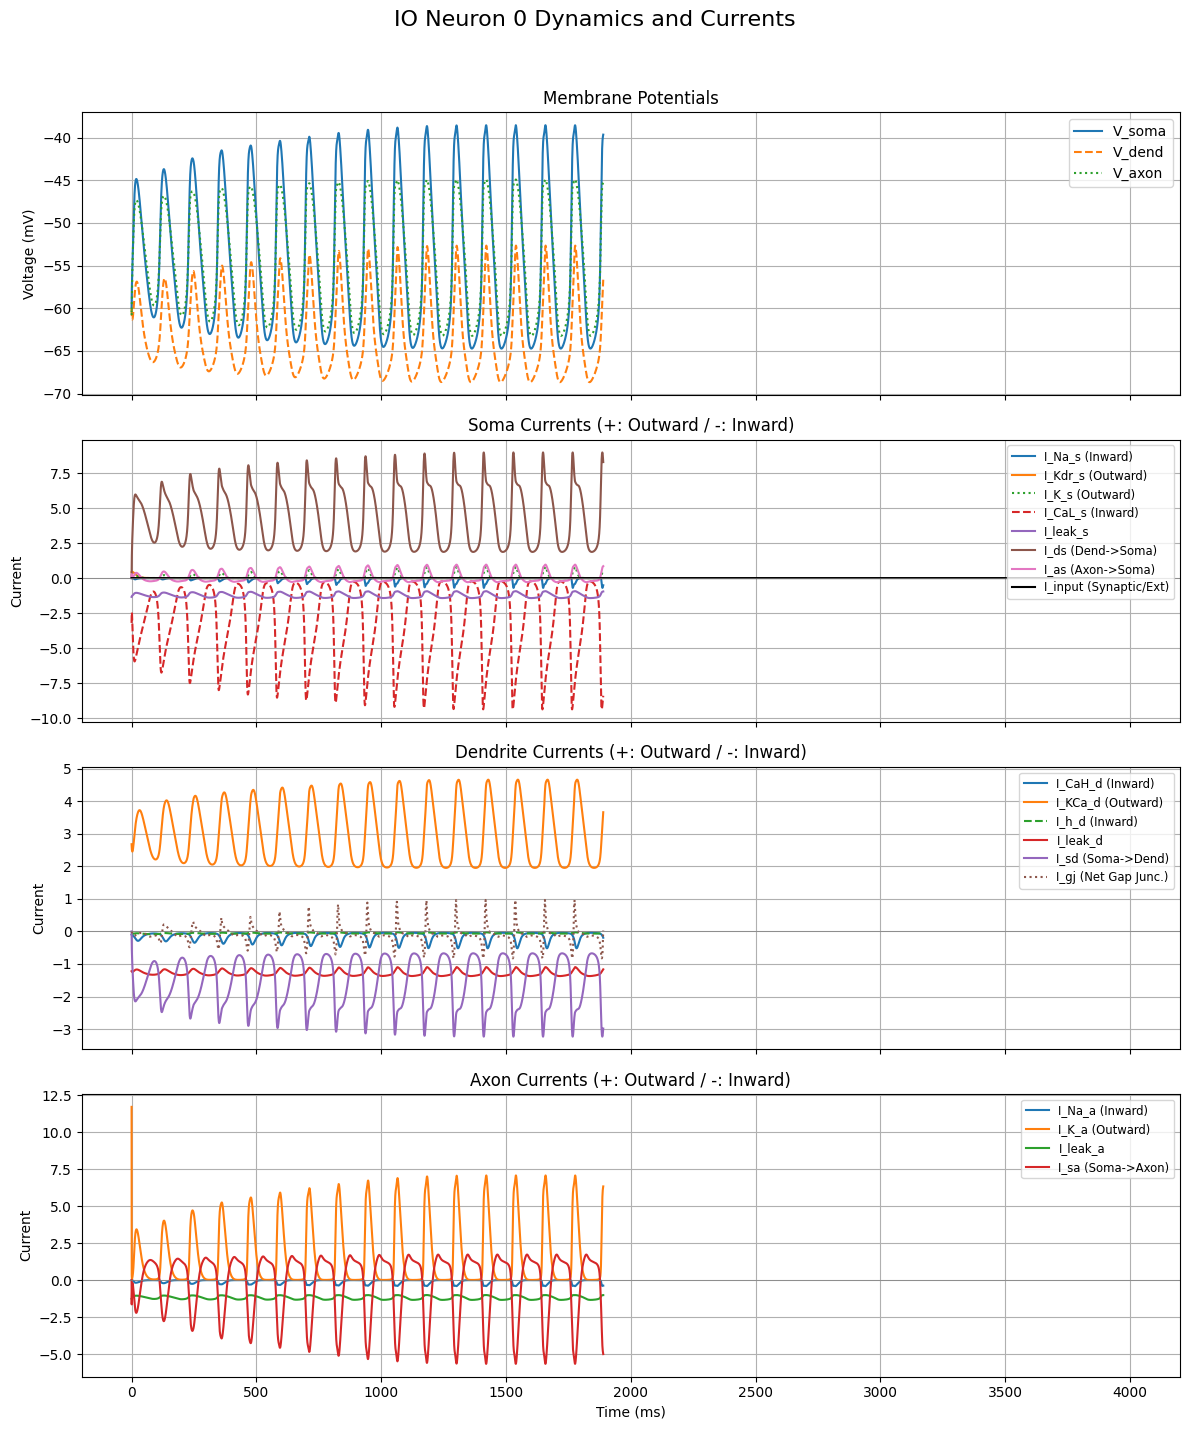

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import brainpy.math as bm # Import brainpy math if needed for data conversion

# --- Configuration ---
# Choose the index of the IO neuron to analyze (replace 0 with the desired index)
io_idx = 0

# Choose the time range to plot (in ms). Set to None to plot the whole duration.
# Example: time_range = (500, 700)
time_range = None # Plot full duration

# --- Data Extraction ---
try:
    ts = np.asarray(runner.mon.ts) # Time vector

    # Voltages
    V_soma = np.asarray(runner.mon['io.V_soma'][:, io_idx])
    V_dend = np.asarray(runner.mon['io.V_dend'][:, io_idx])
    V_axon = np.asarray(runner.mon['io.V_axon'][:, io_idx])

    # Soma Currents
    I_Na_s = np.asarray(runner.mon['io.I_Na_s'][:, io_idx])
    I_Kdr_s = np.asarray(runner.mon['io.I_Kdr_s'][:, io_idx])
    I_K_s = np.asarray(runner.mon['io.I_K_s'][:, io_idx])
    I_CaL_s = np.asarray(runner.mon['io.I_CaL_s'][:, io_idx])
    I_leak_s = np.asarray(runner.mon['io.I_leak_s'][:, io_idx])
    I_ds = np.asarray(runner.mon['io.I_ds'][:, io_idx]) # Dendrite -> Soma
    I_as = np.asarray(runner.mon['io.I_as'][:, io_idx]) # Axon -> Soma
    I_input = np.asarray(runner.mon['io.input'][:, io_idx]) # External/Synaptic Input to Soma

    # Dendrite Currents
    I_CaH_d = np.asarray(runner.mon['io.I_CaH_d'][:, io_idx])
    I_KCa_d = np.asarray(runner.mon['io.I_KCa_d'][:, io_idx])
    I_h_d = np.asarray(runner.mon['io.I_h_d'][:, io_idx])
    I_leak_d = np.asarray(runner.mon['io.I_leak_d'][:, io_idx])
    I_sd = np.asarray(runner.mon['io.I_sd'][:, io_idx]) # Soma -> Dendrite
    I_gj = np.asarray(runner.mon['io.I_gj'][:, io_idx]) # Gap Junction

    # Axon Currents
    I_Na_a = np.asarray(runner.mon['io.I_Na_a'][:, io_idx])
    I_K_a = np.asarray(runner.mon['io.I_K_a'][:, io_idx])
    I_leak_a = np.asarray(runner.mon['io.I_leak_a'][:, io_idx])
    I_sa = np.asarray(runner.mon['io.I_sa'][:, io_idx]) # Soma -> Axon

    data_loaded = True

except KeyError as e:
    print(f"Error loading data: Missing key {e}. Ensure all currents were monitored.")
    data_loaded = False
except NameError:
    print("Error: 'runner' object not found. Please run the simulation first.")
    data_loaded = False

# --- Plotting ---
if data_loaded:
    # Determine time indices for plotting
    if time_range:
        start_idx = np.argmin(np.abs(ts - time_range[0]))
        end_idx = np.argmin(np.abs(ts - time_range[1]))
        t_plot = ts[start_idx:end_idx]
    else:
        start_idx = 0
        end_idx = len(ts)
        t_plot = ts

    # Create figure
    fig_io, axes = plt.subplots(4, 1, figsize=(12, 15), sharex=True)
    fig_io.suptitle(f"IO Neuron {io_idx} Dynamics and Currents", fontsize=16)

    # --- Plot 1: Voltages ---
    ax = axes[0]
    ax.plot(t_plot, V_soma[start_idx:end_idx], label='V_soma')
    ax.plot(t_plot, V_dend[start_idx:end_idx], label='V_dend', linestyle='--')
    ax.plot(t_plot, V_axon[start_idx:end_idx], label='V_axon', linestyle=':')
    ax.set_ylabel("Voltage (mV)")
    ax.set_title("Membrane Potentials")
    ax.legend(loc='upper right')
    ax.grid(True)

    # --- Plot 2: Soma Currents ---
    ax = axes[1]
    ax.plot(t_plot, I_Na_s[start_idx:end_idx], label='I_Na_s (Inward)')
    ax.plot(t_plot, I_Kdr_s[start_idx:end_idx], label='I_Kdr_s (Outward)')
    ax.plot(t_plot, I_K_s[start_idx:end_idx], label='I_K_s (Outward)', linestyle=':')
    ax.plot(t_plot, I_CaL_s[start_idx:end_idx], label='I_CaL_s (Inward)', linestyle='--')
    ax.plot(t_plot, I_leak_s[start_idx:end_idx], label='I_leak_s')
    ax.plot(t_plot, I_ds[start_idx:end_idx], label='I_ds (Dend->Soma)')
    ax.plot(t_plot, I_as[start_idx:end_idx], label='I_as (Axon->Soma)')
    ax.plot(t_plot, I_input[start_idx:end_idx], label='I_input (Synaptic/Ext)', color='black', linewidth=1.5)
    ax.set_ylabel("Current")
    ax.set_title("Soma Currents (+: Outward / -: Inward)")
    ax.legend(loc='upper right', fontsize='small')
    ax.grid(True)
    ax.axhline(0, color='grey', linestyle='-', linewidth=0.5) # Zero line

    # --- Plot 3: Dendrite Currents ---
    ax = axes[2]
    ax.plot(t_plot, I_CaH_d[start_idx:end_idx], label='I_CaH_d (Inward)')
    ax.plot(t_plot, I_KCa_d[start_idx:end_idx], label='I_KCa_d (Outward)')
    ax.plot(t_plot, I_h_d[start_idx:end_idx], label='I_h_d (Inward)', linestyle='--')
    ax.plot(t_plot, I_leak_d[start_idx:end_idx], label='I_leak_d')
    ax.plot(t_plot, I_sd[start_idx:end_idx], label='I_sd (Soma->Dend)')
    ax.plot(t_plot, I_gj[start_idx:end_idx], label='I_gj (Net Gap Junc.)', linestyle=':')
    ax.set_ylabel("Current")
    ax.set_title("Dendrite Currents (+: Outward / -: Inward)")
    ax.legend(loc='upper right', fontsize='small')
    ax.grid(True)
    ax.axhline(0, color='grey', linestyle='-', linewidth=0.5) # Zero line

    # --- Plot 4: Axon Currents ---
    ax = axes[3]
    ax.plot(t_plot, I_Na_a[start_idx:end_idx], label='I_Na_a (Inward)')
    ax.plot(t_plot, I_K_a[start_idx:end_idx], label='I_K_a (Outward)')
    ax.plot(t_plot, I_leak_a[start_idx:end_idx], label='I_leak_a')
    ax.plot(t_plot, I_sa[start_idx:end_idx], label='I_sa (Soma->Axon)')
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Current")
    ax.set_title("Axon Currents (+: Outward / -: Inward)")
    ax.legend(loc='upper right', fontsize='small')
    ax.grid(True)
    ax.axhline(0, color='grey', linestyle='-', linewidth=0.5) # Zero line

    # Adjust layout and show
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()


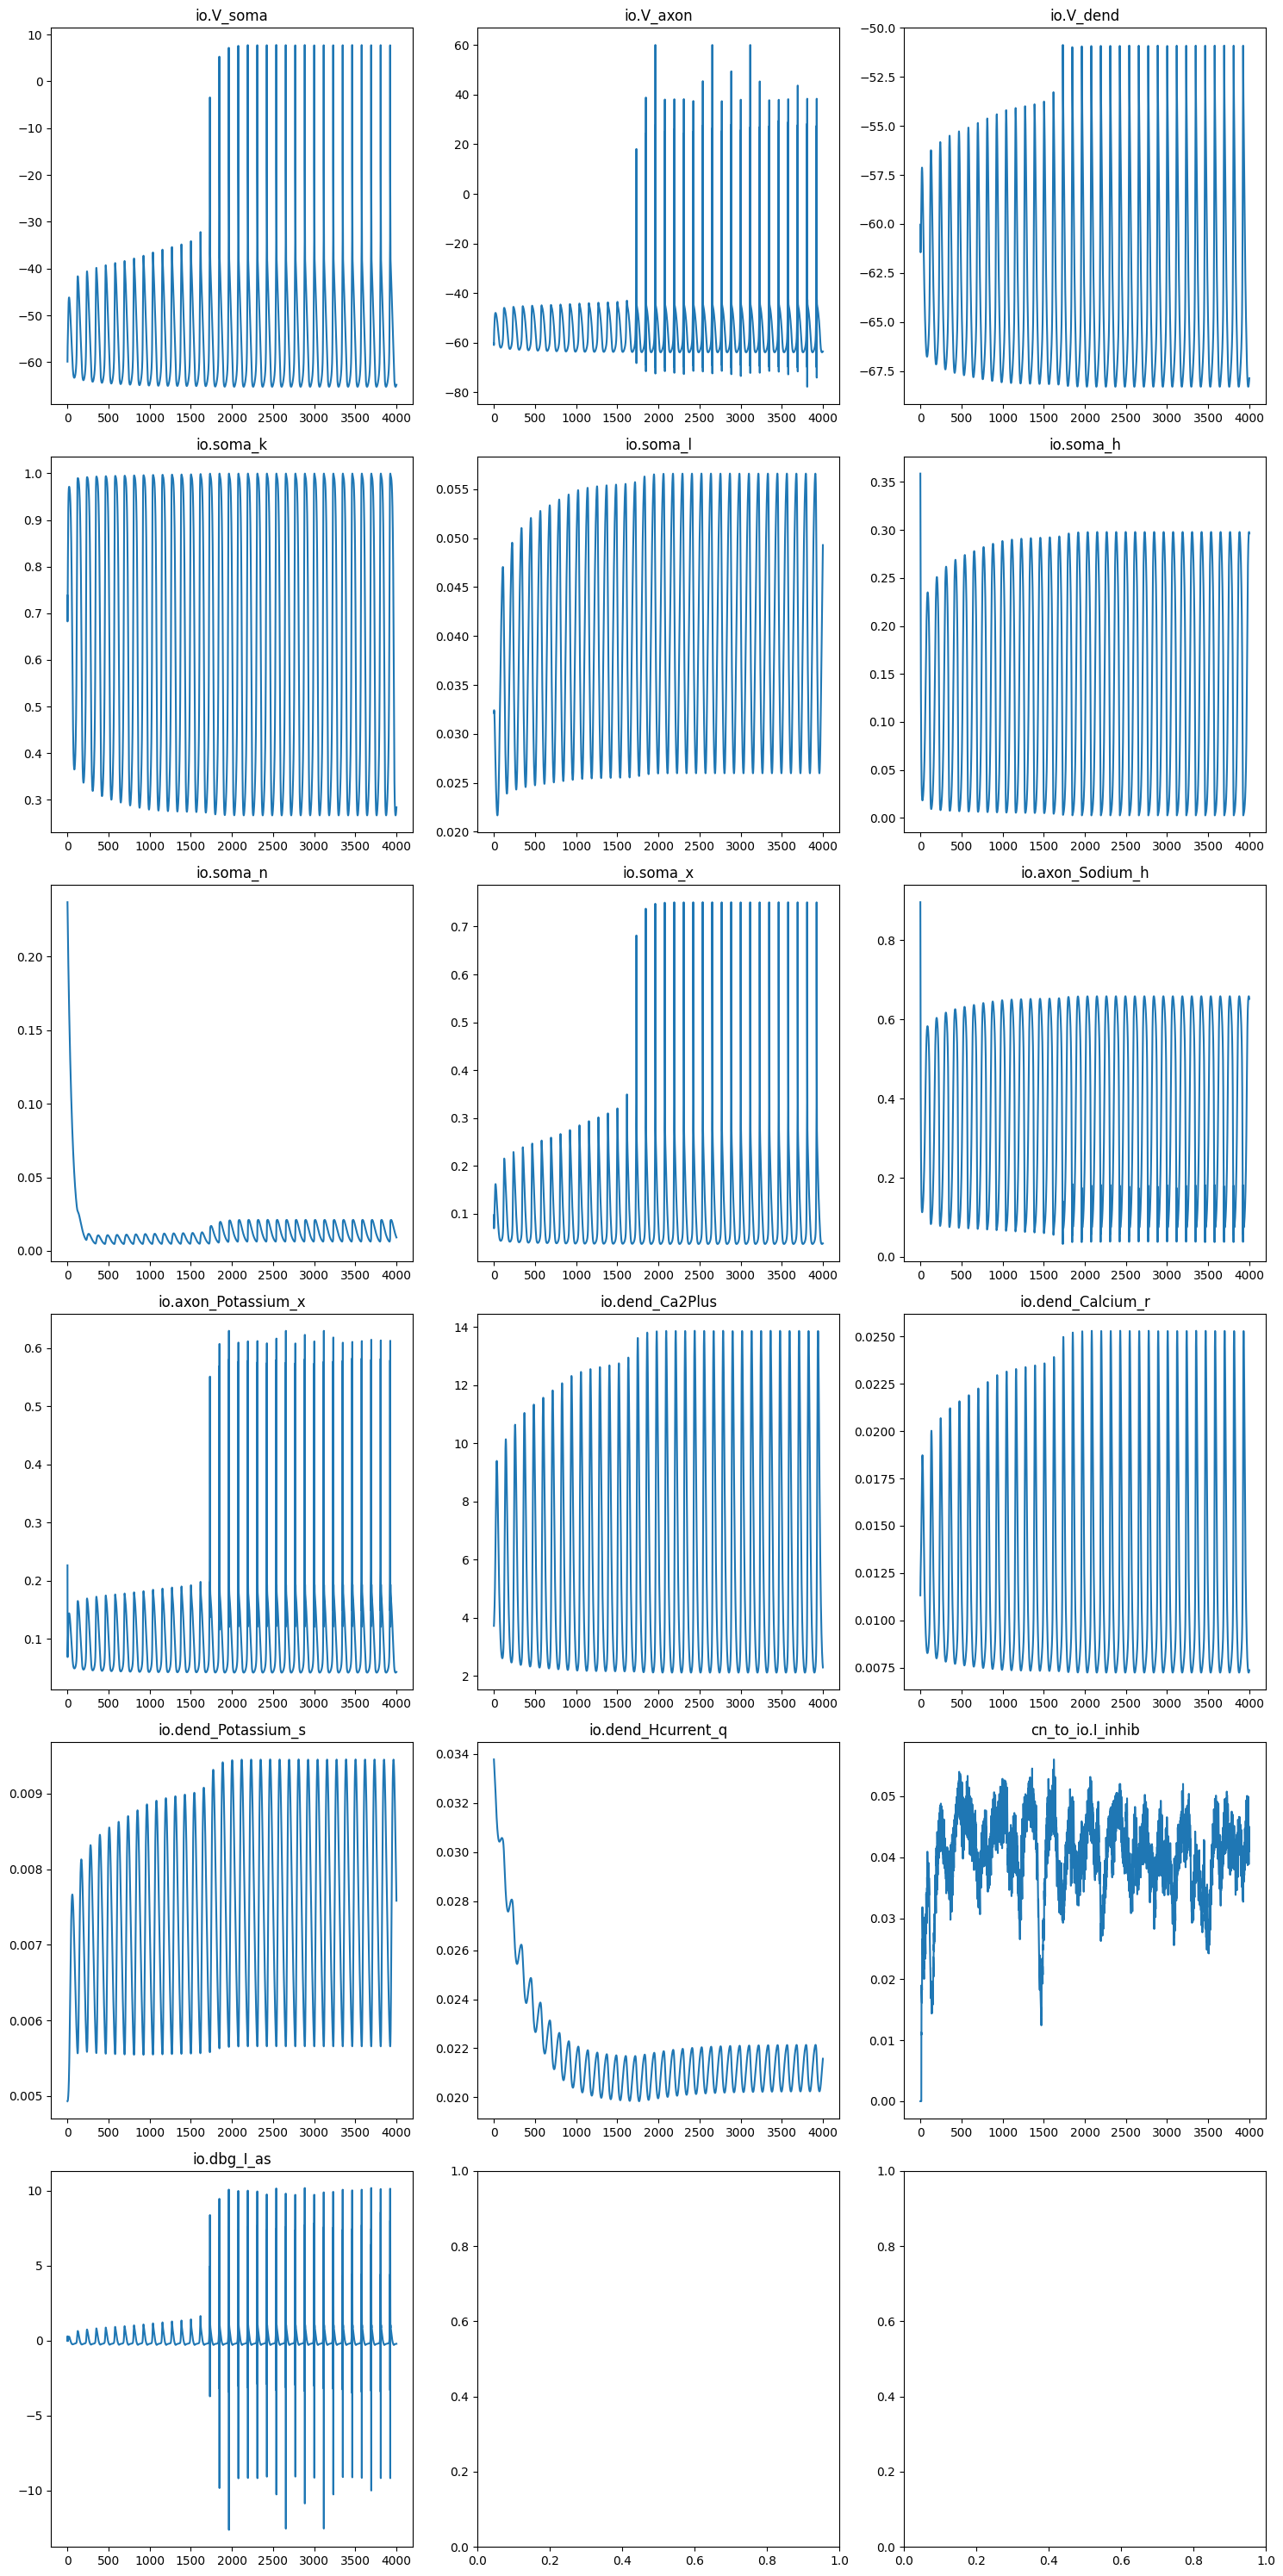

In [7]:
io_vars = {k: mon[k] for k in monitors if "io." in k}
cols = 3
rows = len(io_vars) // cols + (1 if len(io_vars) % cols > 0 else 0)
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axs = axes.flatten()

for i, (k, v) in enumerate(io_vars.items()):
    axs[i].plot(mon.ts, v[:, 12])
    axs[i].set_title(k)

plt.tight_layout()

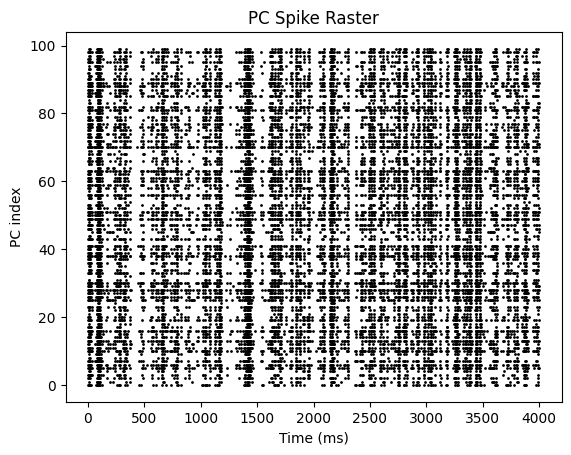

In [3]:
bp.visualize.raster_plot(
    runner.mon.ts,
    runner.mon["pc.spike"],
    xlabel="Time (ms)",
    ylabel="PC index",
    title="PC Spike Raster",
)

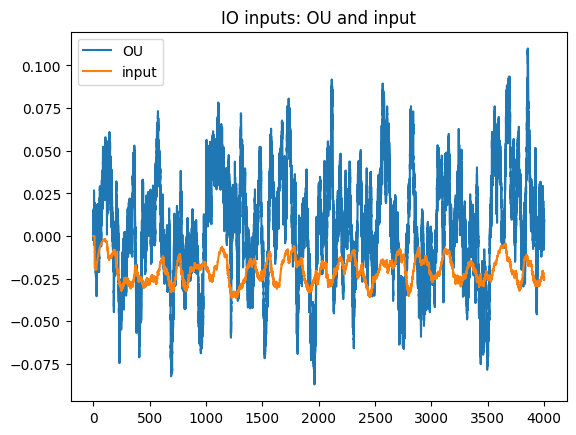

In [3]:
# plot IO inputs: OU and input
plt.plot(mon.ts, np.mean(mon["io.I_OU"], axis=1), label="OU")
plt.plot(mon.ts, np.mean(mon["io.input"], axis=1), label="input")
plt.title("IO inputs: OU and input")
plt.legend()
plt.show()

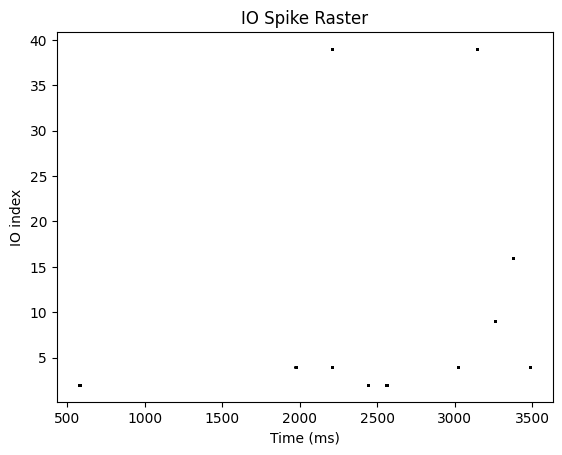

In [4]:
bp.visualize.raster_plot(
    runner.mon.ts,
    runner.mon["io.V_soma"] > -30.0,
    xlabel="Time (ms)",
    ylabel="IO index",
    title="IO Spike Raster",
)

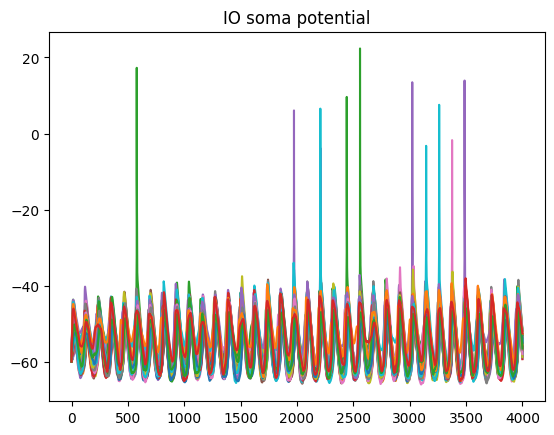

In [5]:
plt.plot(runner.mon.ts,     runner.mon["io.V_soma"][:])
plt.title("IO soma potential")
plt.show()


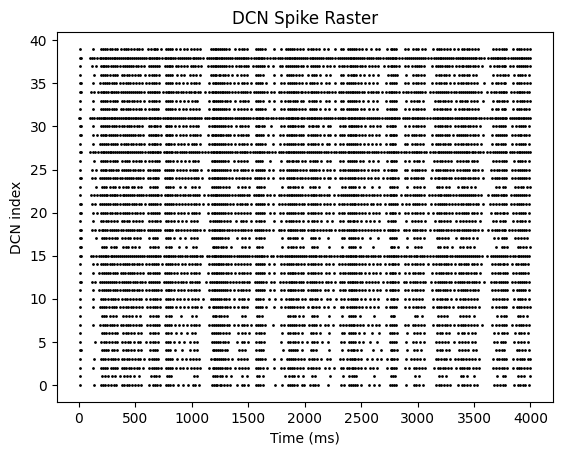

In [7]:
# dcn raster plot
bp.visualize.raster_plot(
    runner.mon.ts,
    runner.mon["cn.spike"],
    xlabel="Time (ms)",
    ylabel="DCN index",
    title="DCN Spike Raster",
)

/var/folders/xd/wcxw_5hn6rz2brc42jwv7f7r0000gn/T/ipykernel_83208/895330963.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


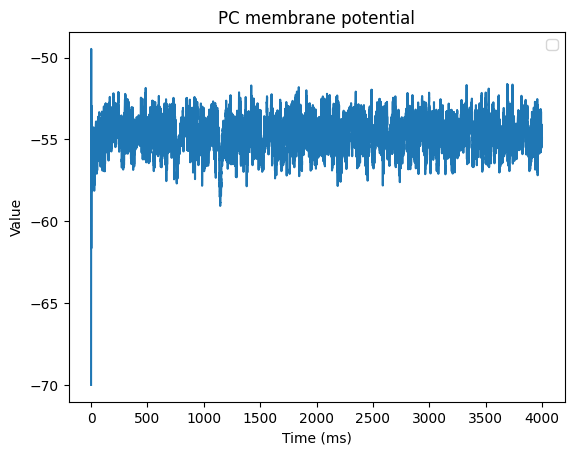

In [11]:
mon = runner.mon

plt.plot(mon.ts, np.mean(mon["pc.V"], axis=1))
# plt.plot(mon.ts, mon["cn_to_io.I_inhib"][:, :5])
plt.xlabel("Time (ms)")
plt.ylabel("Value")
plt.title("PC membrane potential")
plt.legend()
plt.show()

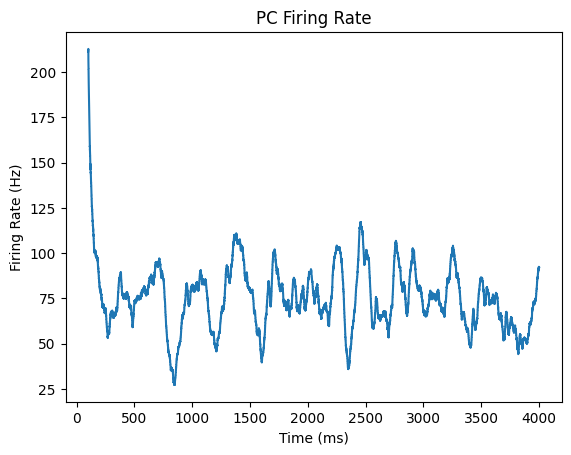

In [14]:
# plot PC firing rate
pc_firing_rate =  calculate_firing_frequency(mon["pc.spike"], mon.ts, 100)

plt.plot(pc_firing_rate[0], pc_firing_rate[1])
plt.xlabel("Time (ms)")
plt.ylabel("Firing Rate (Hz)")
plt.title("PC Firing Rate")
plt.show()


In [12]:
# Define a helper for histogram bins
def _get_bins(data):
    # ... (implementation as before) ...
    if len(data) == 0: return np.arange(2) - 0.5
    min_val = np.min(data); max_val = np.max(data)
    return np.arange(min_val - 0.5, max_val + 1.5, 1)

def plot_network_connectivity(net: bp.DynSysGroup, filename="connectivity_report.png"):
    """
    Generates plots to visualize and verify network connectivity, including
    degree distributions and sparsity patterns.

    Args:
        net: The initialized CerebellarNetwork instance.
        filename: The name of the file to save the plot grid.
    """
    print("Generating connectivity report...")

    try:
        num_pf = net.pf.num
        num_pc = net.pc.num
        num_cn = net.cn.num
        num_io = net.io.neurons.num
        num_io_projecting = num_io // 2
    except AttributeError as e:
        print(f"Error accessing population sizes: {e}")
        return

    fig, axes = plt.subplots(5, 3, figsize=(15, 22)) # 5 rows, 3 cols
    fig.suptitle("Network Connectivity Verification", fontsize=18, y=0.99)

    # --- 1. PF -> PC ---
    ax_pfpc_out, ax_pfpc_in, ax_pfpc_spy = axes[0, 0], axes[0, 1], axes[0, 2]
    try:
        # Use pre2post for PF Out-degree
        post_indices_p2p, post_indptr_p2p = net.pf_to_pc.conn.require('pre2post')
        pf_out_degree = np.diff(np.asarray(post_indptr_p2p))
        ax_pfpc_out.hist(pf_out_degree, bins=_get_bins(pf_out_degree))
        ax_pfpc_out.set_title(f"PF Out-Degree (to PC)")
        ax_pfpc_out.set_xlabel("Number of PC targets per PF")
        ax_pfpc_out.set_ylabel("Count")

        # Use post2pre for PC In-degree
        pre_indices_p2p, pre_indptr_p2p = net.pf_to_pc.conn.require('post2pre')
        pc_in_degree_pf = np.diff(np.asarray(pre_indptr_p2p))
        ax_pfpc_in.hist(pc_in_degree_pf, bins=_get_bins(pc_in_degree_pf))
        ax_pfpc_in.set_title(f"PC In-Degree (from PF, expecting 5)")
        ax_pfpc_in.set_xlabel("Number of PF inputs per PC")
        ax_pfpc_in.set_ylabel("Count")

        # Reconstruct pre_ids/post_ids for sparsity plot from post2pre
        post_ids_rec = np.arange(num_pc).repeat(pc_in_degree_pf)
        pre_ids_rec = np.asarray(pre_indices_p2p)
        if len(pre_ids_rec) == len(post_ids_rec): # Basic check
             conn_matrix_pfpc = csr_matrix((np.ones_like(pre_ids_rec), (pre_ids_rec, post_ids_rec)), shape=(num_pf, num_pc))
             ax_pfpc_spy.spy(conn_matrix_pfpc, markersize=1, aspect='auto')
             ax_pfpc_spy.set_title("PF -> PC Sparsity")
             ax_pfpc_spy.set_xlabel("PC Index")
             ax_pfpc_spy.set_ylabel("PF Index")
        else:
             print("Error reconstructing PF->PC for sparsity plot.")
             ax_pfpc_spy.set_title("PF -> PC Sparsity (Error)")


    except Exception as e:
        print(f"Could not plot PF->PC connectivity: {e}")
        # ... (error handling as before) ...
        ax_pfpc_out.set_title("PF Out-Degree (Error)")
        ax_pfpc_in.set_title("PC In-Degree (PF) (Error)")
        ax_pfpc_spy.set_title("PF -> PC Sparsity (Error)")


    # --- 2. PC -> CN ---
    ax_pccn_out, ax_pccn_in, ax_pccn_spy = axes[1, 0], axes[1, 1], axes[1, 2]
    try:
        # Use pre2post for PC Out-degree
        post_indices_p2p, post_indptr_p2p = net.pc_to_cn.conn.require('pre2post')
        pc_out_degree_cn = np.diff(np.asarray(post_indptr_p2p))
        ax_pccn_out.hist(pc_out_degree_cn, bins=_get_bins(pc_out_degree_cn))
        ax_pccn_out.set_title("PC Out-Degree (to CN, expecting 16)")
        ax_pccn_out.set_xlabel("Number of CN targets per PC")
        ax_pccn_out.set_ylabel("Count")

        # Use post2pre for CN In-degree
        pre_indices_p2p, pre_indptr_p2p = net.pc_to_cn.conn.require('post2pre')
        cn_in_degree_pc = np.diff(np.asarray(pre_indptr_p2p))
        ax_pccn_in.hist(cn_in_degree_pc, bins=_get_bins(cn_in_degree_pc))
        ax_pccn_in.set_title("CN In-Degree (from PC, avg ~40 [30-52])")
        ax_pccn_in.set_xlabel("Number of PC inputs per CN")
        ax_pccn_in.set_ylabel("Count")

        # Reconstruct pre_ids/post_ids for sparsity plot from pre2post
        pre_ids_rec = np.arange(num_pc).repeat(pc_out_degree_cn)
        post_ids_rec = np.asarray(post_indices_p2p)
        if len(pre_ids_rec) == len(post_ids_rec):
            conn_matrix_pccn = csr_matrix((np.ones_like(pre_ids_rec), (pre_ids_rec, post_ids_rec)), shape=(num_pc, num_cn))
            ax_pccn_spy.spy(conn_matrix_pccn, markersize=1, aspect='auto')
            ax_pccn_spy.set_title("PC -> CN Sparsity")
            ax_pccn_spy.set_xlabel("CN Index")
            ax_pccn_spy.set_ylabel("PC Index")
        else:
            print("Error reconstructing PC->CN for sparsity plot.")
            ax_pccn_spy.set_title("PC -> CN Sparsity (Error)")

    except Exception as e:
        print(f"Could not plot PC->CN connectivity: {e}")
        # ... (error handling as before) ...
        ax_pccn_out.set_title("PC Out-Degree (CN) (Error)")
        ax_pccn_in.set_title("CN In-Degree (PC) (Error)")
        ax_pccn_spy.set_title("PC -> CN Sparsity (Error)")


    # --- 3. CN -> IO ---
    ax_cnio_out, ax_cnio_in, ax_cnio_spy = axes[2, 0], axes[2, 1], axes[2, 2]
    try:
        # Use pre2post for CN Out-degree
        post_indices_p2p, post_indptr_p2p = net.cn_to_io.conn.require('pre2post')
        cn_out_degree_io = np.diff(np.asarray(post_indptr_p2p))
        ax_cnio_out.hist(cn_out_degree_io, bins=_get_bins(cn_out_degree_io))
        ax_cnio_out.set_title("CN Out-Degree (to IO, expecting 10)")
        ax_cnio_out.set_xlabel("Number of IO targets per CN")
        ax_cnio_out.set_ylabel("Count")

        # Use post2pre for IO In-degree
        pre_indices_p2p, pre_indptr_p2p = net.cn_to_io.conn.require('post2pre')
        io_in_degree_cn = np.diff(np.asarray(pre_indptr_p2p))
        ax_cnio_in.hist(io_in_degree_cn, bins=_get_bins(io_in_degree_cn))
        avg_in = np.mean(io_in_degree_cn) if len(io_in_degree_cn) > 0 else 0
        ax_cnio_in.set_title(f"IO In-Degree (from CN, avg ~{avg_in:.1f} [6-16])") # Note avg ~6.25 expected
        ax_cnio_in.set_xlabel("Number of CN inputs per IO")
        ax_cnio_in.set_ylabel("Count")

        # Reconstruct pre_ids/post_ids for sparsity plot from pre2post
        pre_ids_rec = np.arange(num_cn).repeat(cn_out_degree_io)
        post_ids_rec = np.asarray(post_indices_p2p)
        if len(pre_ids_rec) == len(post_ids_rec):
            conn_matrix_cnio = csr_matrix((np.ones_like(pre_ids_rec), (pre_ids_rec, post_ids_rec)), shape=(num_cn, num_io))
            ax_cnio_spy.spy(conn_matrix_cnio, markersize=1, aspect='auto')
            ax_cnio_spy.set_title("CN -> IO Sparsity")
            ax_cnio_spy.set_xlabel("IO Index")
            ax_cnio_spy.set_ylabel("CN Index")
        else:
            print("Error reconstructing CN->IO for sparsity plot.")
            ax_cnio_spy.set_title("CN -> IO Sparsity (Error)")

    except Exception as e:
        print(f"Could not plot CN->IO connectivity: {e}")
        # ... (error handling as before) ...
        ax_cnio_out.set_title("CN Out-Degree (IO) (Error)")
        ax_cnio_in.set_title("IO In-Degree (CN) (Error)")
        ax_cnio_spy.set_title("CN -> IO Sparsity (Error)")


    # --- 4. IO -> PC ---
    ax_iopc_out, ax_iopc_in, ax_iopc_spy = axes[3, 0], axes[3, 1], axes[3, 2]
    try:
        # Use post2pre for PC In-degree (expecting 1) and source IOs
        pre_indices_p2p, pre_indptr_p2p = net.io_to_pc.conn.require('post2pre')
        pc_in_degree_io = np.diff(np.asarray(pre_indptr_p2p))
        ax_iopc_in.hist(pc_in_degree_io, bins=_get_bins(pc_in_degree_io))
        ax_iopc_in.set_title("PC In-Degree (from IO, expecting 1)")
        ax_iopc_in.set_xlabel("Number of IO inputs per PC")
        ax_iopc_in.set_ylabel("Count")

        # Calculate Out-degree for projecting IOs using the source indices
        io_source_indices = np.asarray(pre_indices_p2p) # Indices of source IO for each PC
        projecting_mask = io_source_indices < num_io_projecting
        projecting_source_ids = io_source_indices[projecting_mask]

        if num_io_projecting > 0:
             io_out_degree_pc = np.bincount(projecting_source_ids, minlength=num_io_projecting)
             ax_iopc_out.hist(io_out_degree_pc, bins=_get_bins(io_out_degree_pc))
             avg_out = np.mean(io_out_degree_pc) if len(io_out_degree_pc) > 0 else 0
             ax_iopc_out.set_title(f"Projecting IO Out-Degree (to PC, avg ~{avg_out:.1f} [2-9?])") # Note avg ~3.1 expected
        else:
             ax_iopc_out.set_title("Projecting IO Out-Degree (No Proj. IOs!)")
        ax_iopc_out.set_xlabel("Number of PC targets per Projecting IO")
        ax_iopc_out.set_ylabel("Count")

        # Reconstruct pre/post for sparsity plot (only projecting IOs)
        post_ids_rec = np.arange(num_pc)[projecting_mask] # PCs connected to projecting IOs
        pre_ids_rec = projecting_source_ids # Source IOs for these PCs
        if len(pre_ids_rec) == len(post_ids_rec) and num_io_projecting > 0:
             conn_matrix_iopc = csr_matrix((np.ones_like(pre_ids_rec), (pre_ids_rec, post_ids_rec)),
                                          shape=(num_io_projecting, num_pc))
             ax_iopc_spy.spy(conn_matrix_iopc, markersize=1, aspect='auto')
             ax_iopc_spy.set_title(f"IO -> PC Sparsity ({num_io_projecting} Proj. IOs)")
             ax_iopc_spy.set_xlabel("PC Index")
             ax_iopc_spy.set_ylabel("Projecting IO Index")
        else:
             ax_iopc_spy.set_title("IO -> PC Sparsity (Error/No Proj.)")

    except Exception as e:
        print(f"Could not plot IO->PC connectivity: {e}")
        # ... (error handling as before) ...
        ax_iopc_out.set_title("Proj. IO Out-Degree (Error)")
        ax_iopc_in.set_title("PC In-Degree (IO) (Error)")
        ax_iopc_spy.set_title("IO -> PC Sparsity (Error)")


    # --- 5. IO <-> IO (Gap Junctions) ---
    # ... (code remains the same as previous version) ...
    ax_ioio_out, ax_ioio_in, ax_ioio_spy = axes[4, 0], axes[4, 1], axes[4, 2]
    try:
        # Access GJ indices directly from the IONetwork's neuron population
        if hasattr(net.io, 'neurons') and hasattr(net.io.neurons, 'gj_src') and hasattr(net.io.neurons, 'gj_tgt'):
            gj_src = np.asarray(net.io.neurons.gj_src)
            gj_tgt = np.asarray(net.io.neurons.gj_tgt)

            # Out-degree (GJ)
            io_out_degree_gj = np.bincount(gj_src, minlength=num_io)
            ax_ioio_out.hist(io_out_degree_gj, bins=_get_bins(io_out_degree_gj))
            avg_out = np.mean(io_out_degree_gj) if len(io_out_degree_gj) > 0 else 0
            ax_ioio_out.set_title(f"IO Gap Junction Out-Degree (avg ~{avg_out:.1f} [~10])")
            ax_ioio_out.set_xlabel("Number of GJ targets per IO")
            ax_ioio_out.set_ylabel("Count")

            # In-degree (GJ)
            io_in_degree_gj = np.bincount(gj_tgt, minlength=num_io)
            ax_ioio_in.hist(io_in_degree_gj, bins=_get_bins(io_in_degree_gj))
            avg_in = np.mean(io_in_degree_gj) if len(io_in_degree_gj) > 0 else 0
            ax_ioio_in.set_title(f"IO Gap Junction In-Degree (avg ~{avg_in:.1f} [~10])")
            ax_ioio_in.set_xlabel("Number of GJ inputs per IO")
            ax_ioio_in.set_ylabel("Count")

            # Sparsity Plot
            conn_matrix_ioio = csr_matrix((np.ones_like(gj_src), (gj_src, gj_tgt)), shape=(num_io, num_io))
            ax_ioio_spy.spy(conn_matrix_ioio, markersize=1, aspect='auto')
            ax_ioio_spy.set_title("IO <-> IO Gap Junction Sparsity")
            ax_ioio_spy.set_xlabel("Target IO Index")
            ax_ioio_spy.set_ylabel("Source IO Index")
        else:
            print("Gap junction attributes (gj_src, gj_tgt) not found on net.io.neurons.")
            ax_ioio_out.set_title("IO GJ Out-Degree (Not Found)")
            ax_ioio_in.set_title("IO GJ In-Degree (Not Found)")
            ax_ioio_spy.set_title("IO <-> IO GJ Sparsity (Not Found)")


    except Exception as e:
        print(f"Could not plot IO<->IO GJ connectivity: {e}")
        # ... (error handling as before) ...
        ax_ioio_out.set_title("IO GJ Out-Degree (Error)")
        ax_ioio_in.set_title("IO GJ In-Degree (Error)")
        ax_ioio_spy.set_title("IO <-> IO GJ Sparsity (Error)")


    # Adjust layout and save
    fig.tight_layout(rect=[0, 0.01, 1, 0.97])
    plt.show()

Generating connectivity report...


/Users/mablin/Projects/github.com/mablin7/cerebellum-jax/.venv/lib/python3.12/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/mablin/Projects/github.com/mablin7/cerebellum-jax/.venv/lib/python3.12/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/mablin/Projects/github.com/mablin7/cerebellum-jax/.venv/lib/python3.12/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will

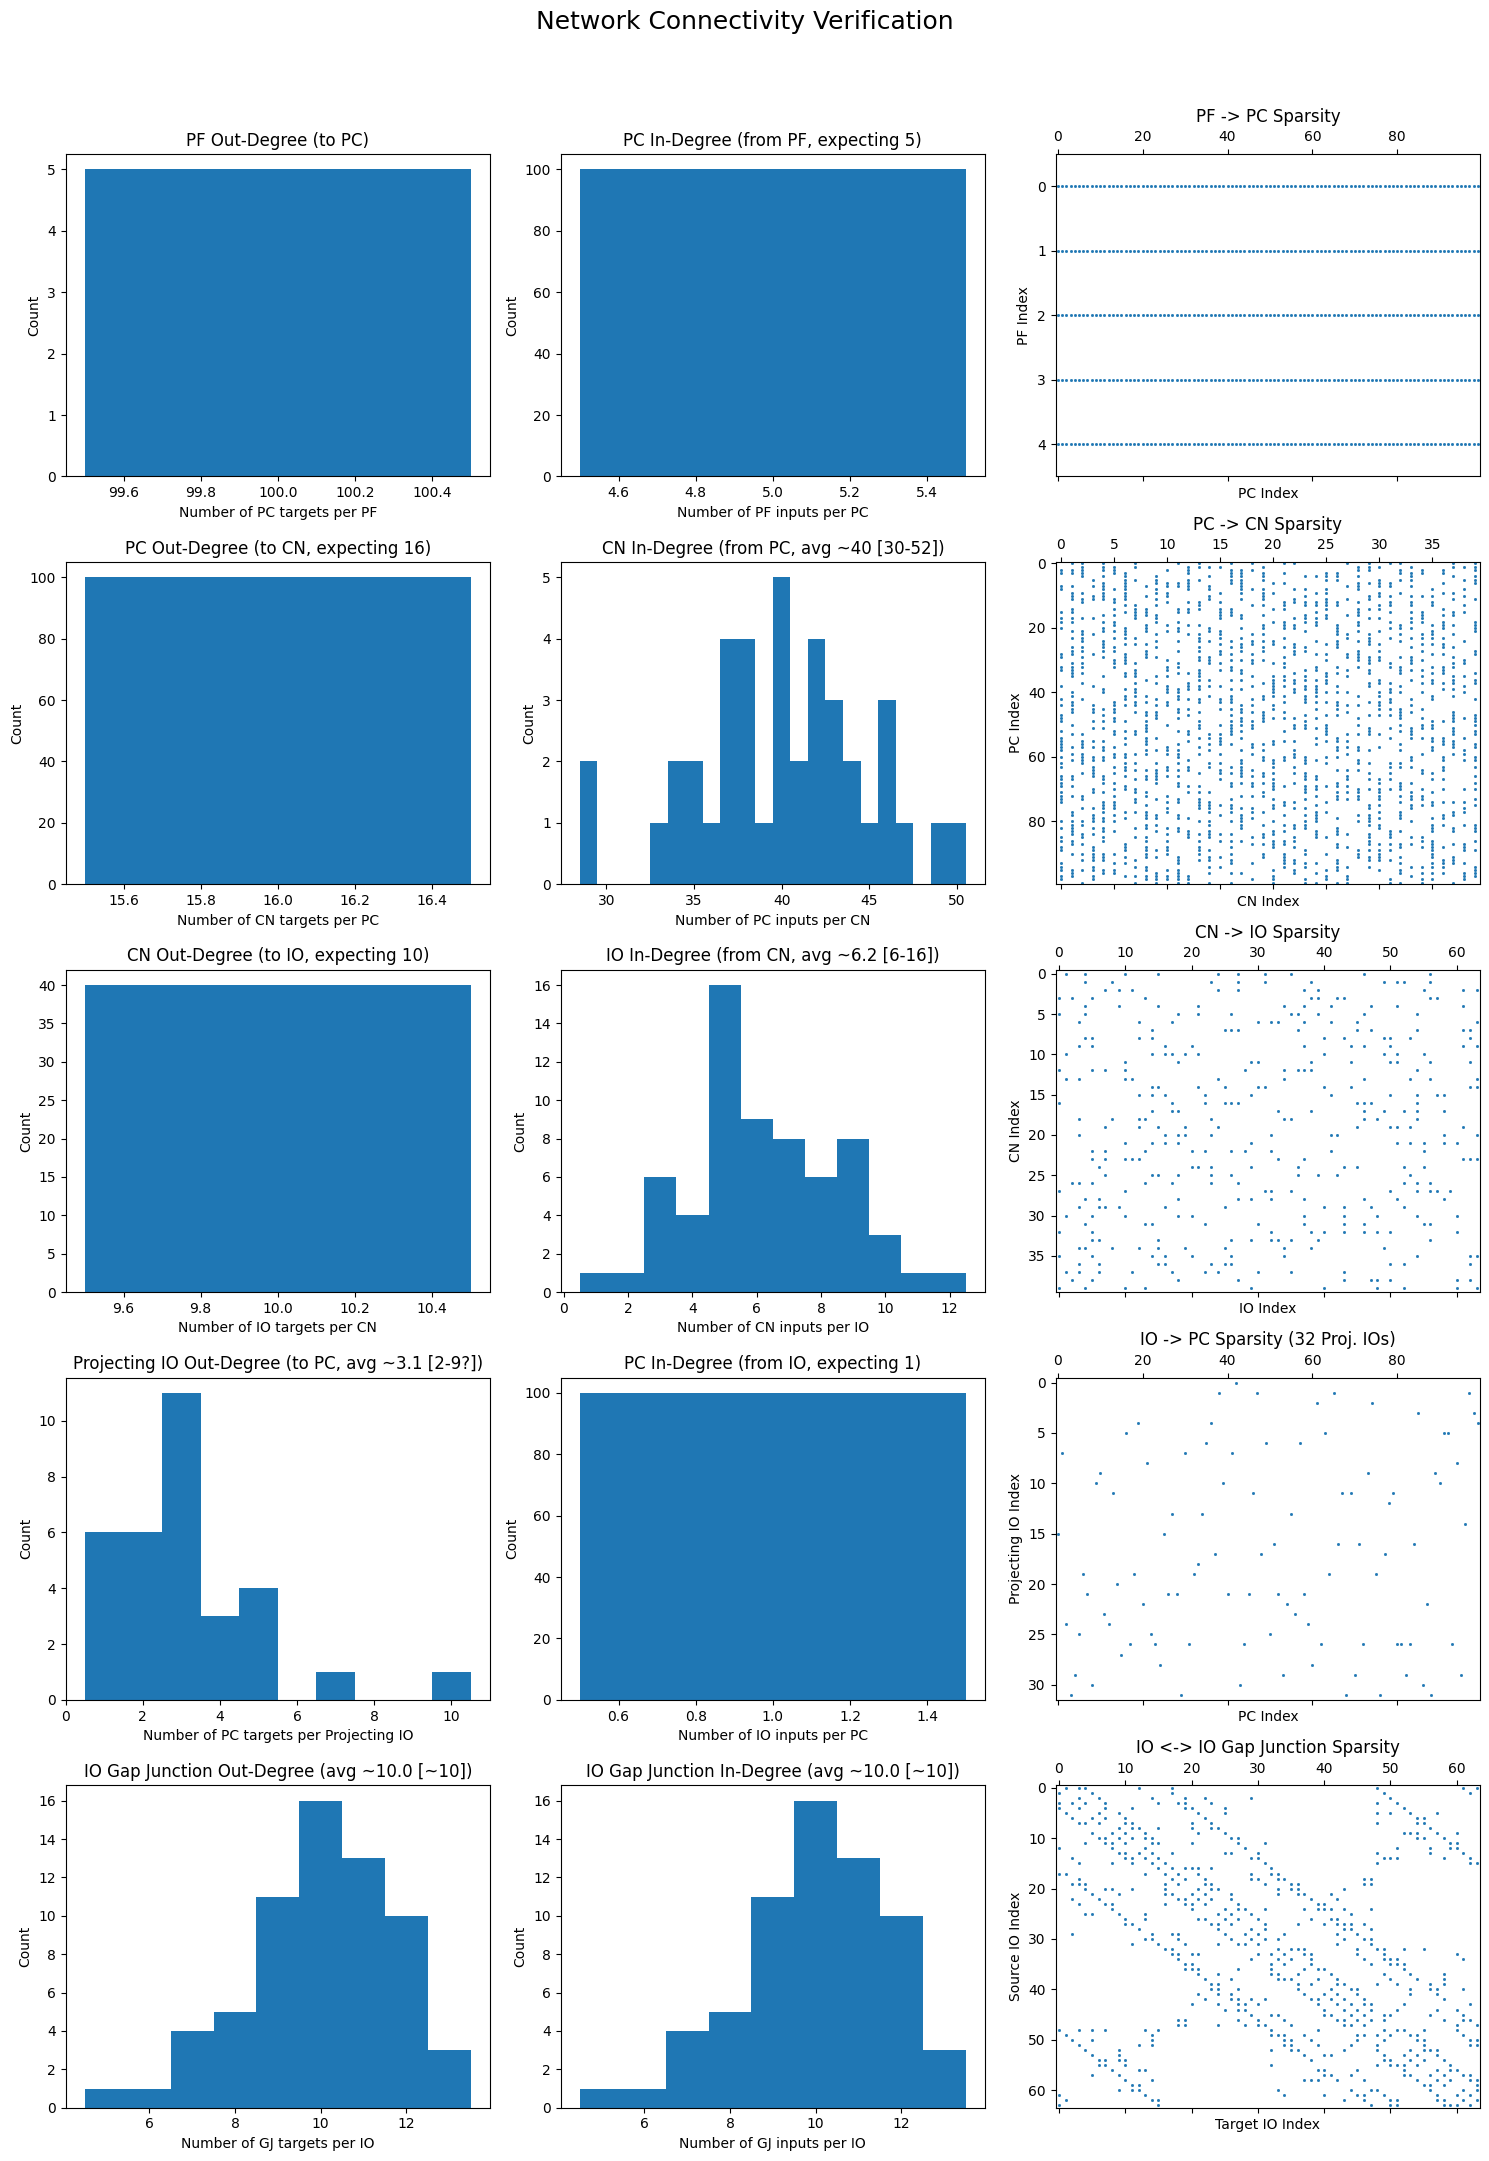

In [13]:
plot_network_connectivity(net)

In [14]:
from models.cells.io import IONetwork

num_io = 5**3
io_params = dict(
    g_Na_s=bm.random.normal(150.0, 1.0, num_io),  # mS/cm2
    g_CaL=0.5
        + 1.2
        * bm.random.rand(
            num_io
        ),
    g_Kdr_s=bm.random.normal(9.0, 0.1, num_io),  # mS/cm2
    g_K_s=bm.random.normal(5.0, 0.1, num_io),  # mS/cm2
    g_h=bm.random.normal(0.12, 0.01, num_io),  # mS/cm2
    g_ls=bm.random.normal(0.017, 0.001, num_io),  # mS/cm2
    g_CaH=bm.random.normal(4.5, 0.1, num_io),  # mS/cm2
    g_K_Ca=bm.random.normal(35.0, 0.5, num_io),  # mS/cm2
    g_ld=bm.random.normal(0.016, 0.001, num_io),  # mS/cm2
    g_Na_a=bm.random.normal(240.0, 1.0, num_io),  # mS/cm2
    g_K_a=bm.random.normal(240.0, 0.5, num_io),  # mS/cm2
    g_la=bm.random.normal(0.017, 0.001, num_io),  # mS/cm2
    V_Na=bm.random.normal(55.0, 1.0, num_io),  # mV
    V_Ca=bm.random.normal(120.0, 1.0, num_io),  # mV
    V_K=bm.random.normal(-75.0, 1.0, num_io),  # mV
    V_h=bm.random.normal(-43.0, 1.0, num_io),  # mV
    V_l=bm.random.normal(10.0, 1.0, num_io),  # mV
    S=bm.random.normal(1.0, 0.1, num_io),  # 1/C_m, cm^2/uF
    g_int=bm.random.normal(
        0.13, 0.001, num_io
    ),  # Cell internal conductance - no unit given
    p1=bm.random.normal(
        0.25, 0.01, num_io
    ),  # Cell surface ratio soma/dendrite - no unit given
    p2=bm.random.normal(
        0.15, 0.01, num_io
    ),  # Cell surface ratio axon(hillock)/soma - no unit given
)
io_network = IONetwork(num_neurons=num_io, g_gj=0.05, nconnections=10, **io_params)

# Create a runner to simulate the model
bm.set_dt(0.025)
runner = bp.DSRunner(
    io_network,
    monitors=["neurons.V_soma", "neurons.V_axon", "neurons.V_dend"],
    dt=0.025,  # Matching the delta in the original code
)
runner.run(4_000.0)
mon = runner.mon

Predict 160000 steps: : 100%|██████████| 160000/160000 [00:23<00:00, 6867.79it/s] 


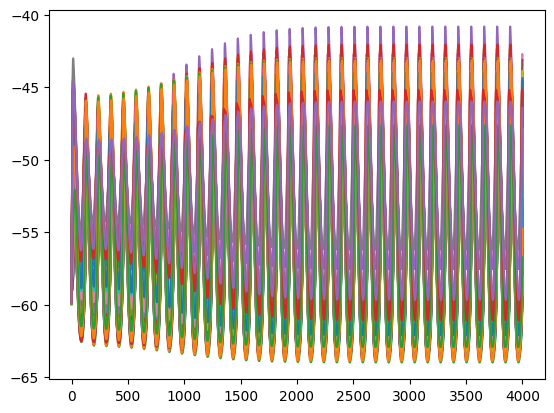

In [15]:
plt.plot(runner.mon.ts, runner.mon["neurons.V_soma"][:])
plt.show()